In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import time
import os

# proxyの設定．
# keras.datasetsでは，datasetを直接ダウンロードするので，学内マシンからは通常必要．
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"      # "0":GPU0, "1":GPU1, "0,1":GPUを2つとも使用

import numpy as np
import keras
import keras.datasets

Using TensorFlow backend.
using GPU: 1


In [2]:
#  mnist データの読み込み．初回実行時はダウンロードする．
(x_train, y_train),(x_test,y_test) = keras.datasets.mnist.load_data()
print(x_train.shape, y_train.shape)
print(np.min(x_train),np.max(x_train))

#[0,255]の値を[0,1]に正規化して，(サンプル数，高さ，幅，チャネル数)に変形
# 畳み込み層入力用．
x_train = x_train.reshape(60000,28,28,1).astype('float32') / 255.0
x_test = x_test.reshape(10000,28,28,1).astype('float32') / 255.0

# 28x28の画像を全結合入力用に，784次元にベクトル化．(サンプル数，784次元)
X_train = x_train.reshape(60000,784).astype('float32')
X_test = x_test.reshape(10000,784).astype('float32')

# 1 of Kのベクトルに変換
Y_train = keras.utils.to_categorical(y_train, 10)
Y_test = keras.utils.to_categorical(y_test, 10)

((60000, 28, 28), (60000,))
(0, 255)


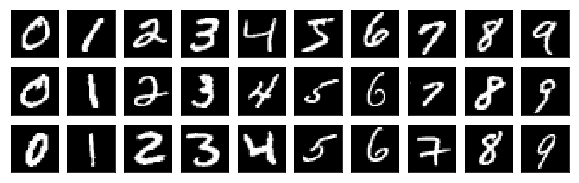

In [3]:
#MNISTデータの表示
fig = plt.figure(figsize=(10, 3))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    idx= y_train==i %10
    X=X_train[idx]
    ax.imshow(X[i//10].reshape((28, 28)), cmap='gray')

In [4]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dropout

# まずは，全結合2層だけで，分類してみます．
model = Sequential()
model.add(Dense(30, input_dim=784, activation='relu'))
model.add(Dense(30, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(10, activation='softmax'))

In [5]:
from keras.optimizers import SGD

# MomentumSDGを使う．
model.compile(loss="categorical_crossentropy", 
              optimizer=SGD(lr=0.01, momentum=0.9),
              metrics=["accuracy"])

In [6]:
# callback のクラス ShowGraphを定義
class ShowGraph(keras.callbacks.Callback):
    def __init__(self,max_epoch):
        # 表示エリアの設定
        self.fig=plt.figure()
        self.fig1 = self.fig.add_subplot(121)
        self.fig1.axis([0, max_epoch, 0.9, 1.0])
        self.fig1.set_title('accuracy')
        self.fig1.set_ylabel('accuracy')
        self.fig1.set_xlabel('epoch')
        self.fig2 = self.fig.add_subplot(122)
        self.fig2.axis([0, max_epoch, 0, 0.3 ])
        self.fig2.set_title('loss')
        self.fig2.set_ylabel('loss')
        self.fig2.set_xlabel('epoch')
        self.max_epoch=max_epoch
        self.start=time.time()
    
    # 学習の最初に呼び出される
    def on_train_begin(self, logs={}):
        self.losses=[]
        self.losses_val=[]
        self.acc=[]
        self.acc_val=[]
        self.n_epoch=[]
    
    # 各epochの最後に呼び出される
    def on_epoch_end(self, epoch, logs={}):
        self.n_epoch.append(epoch)
        self.acc.append(logs.get('acc'))
        self.acc_val.append(logs.get('val_acc'))     
        self.losses.append(logs.get('loss'))
        self.losses_val.append(logs.get('val_loss'))     
        self.test_acc=logs.get('val_acc')
    
        display.clear_output(wait = True)
        self.fig1.plot(self.n_epoch,self.acc,"b")
        self.fig1.plot(self.n_epoch,self.acc_val,"r")
        self.fig1.legend(['train', 'test'], loc='upper left')
        self.fig2.plot(self.n_epoch,self.losses,"b")
        self.fig2.plot(self.n_epoch,self.losses_val,"r")
        self.fig2.legend(['train', 'test'], loc='upper right')
        display.display(self.fig)
        
    # デストラクタ(オブジェクトが消滅時に実行される)  
    # グラフが２つ表示されるのを防止．さらに最終val acc値の表示．
    def __del__(self):
        display.clear_output(wait = True)
        print("val_acc: ",self.test_acc) 
        print('Time: ',time.time()-self.start)

('val_acc: ', 0.97019998550415043)
('Time: ', 56.9467499256134)


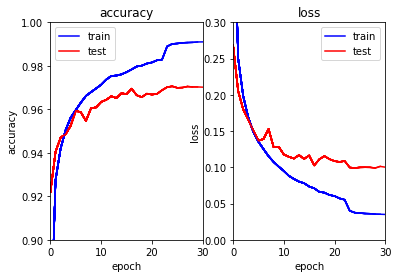

In [7]:
num_epoch=30
show_graph=ShowGraph(num_epoch)
reduce_lr =keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=5, min_lr=0.0001)
# history = model.fit(X_train, Y_train, epochs=num_epoch+1, validation_data=(X_test,Y_test), batch_size=100, verbose=0, callbacks=[show_graph])
history = model.fit(X_train, Y_train, epochs=num_epoch+1, validation_data=(X_test,Y_test), batch_size=100, verbose=0, callbacks=[show_graph,reduce_lr])
del show_graph

In [7]:
model2 = Sequential()
model2.add(Conv2D(30, 3, padding='same', activation='relu', input_shape=(28, 28, 1), kernel_initializer='he_normal'))
#model2.add(Dropout(0.5))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Conv2D(30, 3, padding='same', activation='relu', kernel_initializer='he_normal'))
#model2.add(Dropout(0.5))
model2.add(BatchNormalization())
model2.add(Flatten()) # Keras の場合，conv から dense に移行する時には，テンソルをベクトルに変換する操作(Flatten)が必要です．
model2.add(Dense(10, activation='softmax'))

In [8]:
model2.compile(loss="categorical_crossentropy", 
              optimizer=SGD(lr=0.01, momentum=0.9),
              metrics=["accuracy"])

('val_acc: ', 0.98959998667240145)
('Time: ', 153.63263702392578)


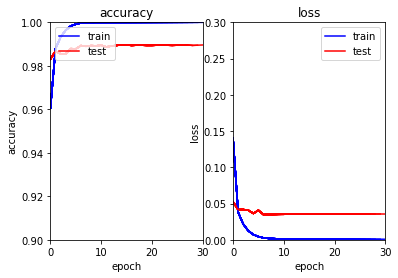

In [9]:
num_epoch=30
show_graph2=ShowGraph(num_epoch)
reduce_lr2 =keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=5, min_lr=0.0001)
history2 = model2.fit(x_train, Y_train, epochs=num_epoch+1, validation_data=(x_test,Y_test), batch_size=100, verbose=0, callbacks=[show_graph2, reduce_lr2])
del show_graph2

### 課題3
以下の小問の(1)-(3)を解答すること．(4）は任意回答．

1. 全結合のみ(30, 30, 10)のmodel, 畳み込み(30, 30)＋全結合(10)のmodel2 のそれぞれのパラメータ数(Wのみ，バイアスは除く）を計算し，全結合と畳み込みの違いをパラメータ数と認識性能の観点から考察せよ．
1. 学習のaccuracy/lossのグラフで青線(training), 赤線(validation)が乖離すると，過学習になっているとみなすことができる．それを解決するために，全結合のみのmodel, 畳み込み＋全結合のmodel2 のそれぞれにDropoutを追加するとどうなるか実験せよ．なお，modelには，2番目の全結合の後に0.2の割合で，model2には2つの畳み込みの直後に割合0.5でそれぞれ挿入せよ．(コメントアウトしてある行の # をとればよい．) (全結合はパラメータが多いので，0.5の割合で挿入する場合は epoch数を増やさないと十分に学習ができない．興味があれば試してみよ．)
1. model2に BatchNormalizationを追加せよ．その際，Dropoutを使ったほうがいいか，使わないほうがいいか比較せよ．
1. OptimizerをAdamに変更して，MomentumSDGとの結果の違いを観察せよ．

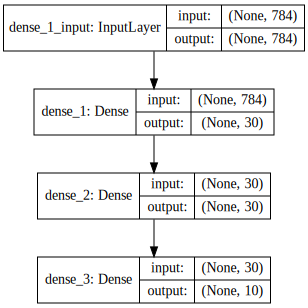

In [11]:
# 最初のmodel の表示
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

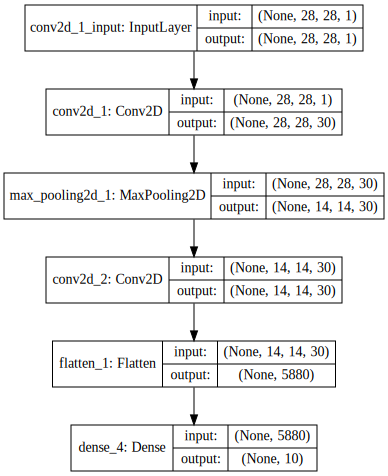

In [12]:
# 2つ目のモデルの表示
SVG(model_to_dot(model2, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

dropout nasi